**Importing Libraries**

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta
import math
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pickle
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

**Reading the Data**

In [2]:
data = pd.read_csv('FinalData.csv')
data = data.iloc[::-1]

In [3]:
cgm_data = data['Value CGM'].to_numpy()
bolus_data = data['Value Bolus'].to_numpy()

In [4]:
total_cgm = cgm_data[bolus_data > 0]

In [5]:
plt.bar(list(Counter(total_cgm).keys()), list(Counter(total_cgm).values()),color='blue')

<BarContainer object of 240 artists>

**Preparing the Data for RNN input by performing TimeShift**

In [6]:
def get_timeshift(items, time_stamps, shift):
    data = pd.DataFrame(items)
    col = col = [data.shift(i) for i in range(time_stamps, -1*shift, -1)]
    data = pd.concat(col, axis=1)
    data.columns = list(range(0, len(data.columns)))
    data = data.dropna(how='any', axis=0)
    return data.to_numpy()

In [7]:
time_stamps = 100
shift=4
data_rnn = pd.DataFrame(get_timeshift(cgm_data, time_stamps, shift))
data_rnn

0      1      2      3      4      5      6      7      8      9    \
0      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
1      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
2      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
3      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
4      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
34992   90.0  101.0  115.0  129.0   79.0   69.0   49.0   49.0   49.0   49.0   
34993  101.0  115.0  129.0   79.0   69.0   49.0   49.0   49.0   49.0   49.0   
34994  115.0  129.0   79.0   69.0   49.0   49.0   49.0   49.0   49.0   73.0   
34995  129.0   79.0   69.0   49.0   49.0   49.0   49.0   49.0   73.0   83.0   
34996   79.0   69.0   49.0   49.0   49.0   49.0   49.0   73.0   83.0   90.0   

       ...    94     95     96     97     98     99     100    101    102  \
0      ...   81.0   81.0   92.0   93.0   89.0   99.0  106.0  114.0  115.0   
1      ...   81.0   92.0   93.0   89.0   99.0  106.0  114.0  115.0  115.0   
2      ...   92.0   93.0   89.0   99.0  106.0  114.0  115.0  115.0  115.0   
3      ...   93.0   89.0   99.0  106.0  114.0  115.0  115.0  115.0  124.0   
4      ...   89.0   99.0  106.0  114.0  115.0  115.0  115.0  124.0  112.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
34992  ...  134.0  131.0  140.0  150.0  140.0  137.0  130.0  128.0  127.0   
34993  ...  131.0  140.0  150.0  140.0  137.0  130.0  128.0  127.0  126.0   
34994  ...  140.0  150.0  140.0  137.0  130.0  128.0  127.0  126.0  124.0   
34995  ...  150.0  140.0  137.0  130.0  128.0  127.0  126.0  124.0  122.0   
34996  ...  140.0  137.0  130.0  128.0  127.0  126.0  124.0  122.0  118.0   

         103  
0      115.0  
1      115.0  
2      124.0  
3      112.0  
4      119.0  
...      ...  
34992  126.0  
34993  124.0  
34994  122.0  
34995  118.0  
34996  118.0  

[34997 rows x 104 columns]

**Getting the static features of the data to input in GRU static layer**

In [10]:
def get_static_features(items):
    data = pd.DataFrame(items)
    result = pd.DataFrame()
    result['mean'] = data.mean(axis=1)
    result['median']= data.median(axis=1)
    result["std"] = data.std(axis=1)
    result['iqr'] = data.quantile(0.75,axis=1)-data.quantile(0.25,axis=1)
    result['low'] = data.min(axis=1)
    result['high'] = data.max(axis=1)
    result['gfi'] = ((data.diff(axis=1)**2).mean(axis=1))**0.5
    result['mag'] = data.diff(axis=1).abs().mean(axis=1)
    result['gcf'] = result['gfi'] / result['mean']
    result['cv'] = (result['std']*100) / result['mean']
    return result.to_numpy()

In [11]:
data_static = pd.DataFrame(get_static_features(data_rnn.iloc[:,0:100].to_numpy()))
data_static

0      1           2       3     4      5          6         7  \
0      201.19  278.0  117.405685  241.25  43.0  314.0  18.319554  6.393939   
1      199.11  278.0  117.229284  241.25  43.0  314.0  18.333058  6.464646   
2      197.11  221.0  116.955132  241.25  43.0  314.0  18.350680  6.545455   
3      195.12  151.0  116.638722  241.25  43.0  314.0  18.350956  6.555556   
4      193.13  136.0  116.287058  241.25  43.0  314.0  18.350956  6.555556   
...       ...    ...         ...     ...   ...    ...        ...       ...   
34992  130.28  147.0   39.151630   54.75  49.0  194.0   9.565827  5.383838   
34993  130.68  147.0   38.939705   54.25  49.0  194.0   9.527737  5.343434   
34994  130.95  147.0   38.825269   52.00  49.0  194.0   9.425412  5.222222   
34995  131.07  147.0   38.794005   52.00  49.0  194.0   9.320337  5.090909   
34996  131.04  147.0   38.796782   52.00  49.0  194.0   7.850240  4.595960   

              8          9  
0      0.091056  58.355626  
1      0.092075  58.876643  
2      0.093099  59.334956  
3      0.094050  59.777943  
4      0.095019  60.211805  
...         ...        ...  
34992  0.073425  30.051911  
34993  0.072909  29.797754  
34994  0.071977  29.648926  
34995  0.071110  29.597929  
34996  0.059907  29.606824  

[34997 rows x 10 columns]

**Preapring the training and testing data**

In [14]:
def train_test_splits(items, split_per=0.8):
    data = pd.DataFrame(items)
    train_size = int(len(data) * split_per)
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    return train.to_numpy(), test.to_numpy()

In [15]:
gru_train, gru_test = train_test_splits(data_rnn.to_numpy())
X_train, X_test = train_test_splits(data_static.to_numpy())

In [16]:
def get_moving_diff(items, replace_na=False):
    data = pd.DataFrame(items)
    diff_X = data.diff(axis=1)
    if replace_na:
        diff_X = diff_X.fillna(0.0)
    else:
        diff_X = diff_X.dropna(axis=1)
    return diff_X.to_numpy()

In [17]:
gru_train = get_moving_diff(gru_train, True)
gru_test = get_moving_diff(gru_test, True)

In [18]:
def rescale(value, newscale=(-1,1), oldscale=(-100,100)):
    (old_min, old_max) = oldscale
    (new_min, new_max) = newscale
    new_value= (new_max-new_min)/(old_max-old_min)*(value-old_max)+new_max
    return new_value

In [19]:
gru_train = np.vectorize(rescale)(gru_train)
gru_test = np.vectorize(rescale)(gru_test)

In [20]:
X_gru_train, Y_train = gru_train[:,0:time_stamps], gru_train[:,time_stamps:]
X_gru_test, Y_test = gru_test[:,0:time_stamps], gru_test[:,time_stamps:]

In [21]:
print(X_gru_train.shape, X_gru_test.shape)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(27997, 100) (7000, 100)
(27997, 10) (7000, 10)
(27997, 4) (7000, 4)


In [23]:
scaler = StandardScaler()
scaler.fit(X_train,Y_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_gru_train = np.expand_dims(X_gru_train, axis=-1)
X_gru_test = np.expand_dims(X_gru_test, axis=-1)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [25]:
print(X_gru_train.shape, X_gru_test.shape)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(27997, 100, 1) (7000, 100, 1)
(27997, 10, 1) (7000, 10, 1)
(27997, 4) (7000, 4)


In [26]:
def r_square(y_true, y_pred):
    from keras import backend as K 
    SS_total = K.sum(K.square(y_true - K.mean(y_true)))
    SS_result =  K.sum(K.square(y_true - y_pred)) 
    return ( 1 - SS_result/(SS_total + K.epsilon()) )

**Defining the model**

In [219]:
model = keras.Sequential()

gru_input = layers.Input(shape=(X_gru_train.shape[1], X_gru_train.shape[2]))
static_input = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

gru_stack_1, gru_stack_1_c = layers.GRU(100, return_sequences=True, return_state=True)(gru_input)
drop_gru_1 = layers.Dropout(0.05)(gru_stack_1)

gru_stack_2, gru_stack_2_c = layers.GRU(100, return_sequences=True, return_state=True)(drop_gru_1)

static_dense = layers.Dense(2)(static_input)
static_flatten = layers.Flatten()(static_dense)

concatenate = layers.Concatenate()([gru_stack_1_c, gru_stack_2_c, static_flatten])


drop_2 = layers.Dropout(0.1)(concatenate)
dense_1 = layers.Dense(64)(drop_2)
drop_3 = layers.Dropout(0.05)(dense_1)
dense_2 = layers.Dense(16)(drop_3)
drop_4 = layers.Dropout(0.02)(dense_2)

output = layers.Dense(4)(drop_4)


model = models.Model(inputs=[gru_input, static_input], outputs=output)
model.summary()
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=[r_square,'mae']
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 gru_8 (GRU)                    [(None, 100, 100),   30900       ['input_9[0][0]']                
                                 (None, 100)]                                                     
                                                                                                  
 input_10 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 dropout_16 (Dropout)           (None, 100, 100)     0           ['gru_8[0][0]']            

**Training the model**

In [220]:
filepath = "model_gru_static-{epoch:03d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='r_square', verbose=1,
    save_best_only=False, save_weights_only=True, mode='auto', period=1)

history = model.fit(
    [X_gru_train, X_train], Y_train,
    epochs=10,
    batch_size=48,
    verbose=1,
    validation_data=([X_gru_test, X_test], Y_test),
    shuffle=True,
    callbacks=[checkpoint]
)

Epoch 1/10
584/584 [==============================] - ETA: 0s - loss: 0.0389 - r_square: -1.2054 - mae: 0.1112
Epoch 00001: saving model to model_gru_static-001.h5
584/584 [==============================] - 135s 221ms/step - loss: 0.0389 - r_square: -1.2054 - mae: 0.1112 - val_loss: 0.0194 - val_r_square: -0.0744 - val_mae: 0.0666
Epoch 2/10
584/584 [==============================] - ETA: 0s - loss: 0.0221 - r_square: -0.1181 - mae: 0.0765
Epoch 00002: saving model to model_gru_static-002.h5
584/584 [==============================] - 124s 213ms/step - loss: 0.0221 - r_square: -0.1181 - mae: 0.0765 - val_loss: 0.0191 - val_r_square: -0.0621 - val_mae: 0.0658
Epoch 3/10
584/584 [==============================] - ETA: 0s - loss: 0.0210 - r_square: -0.0551 - mae: 0.0711
Epoch 00003: saving model to model_gru_static-003.h5
584/584 [==============================] - 123s 210ms/step - loss: 0.0210 - r_square: -0.0551 - mae: 0.0711 - val_loss: 0.0190 - val_r_square: -0.0433 - val_mae: 0.0652
E

**Plotting the results of training**

In [245]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig1.suptitle('Mean Square Error')
ax1.plot(history.history['loss'],color='blue')
ax2.plot(history.history['val_loss'],color='yellow')

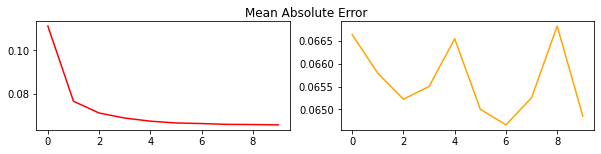

In [246]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig2.suptitle('Mean Absolute Error')
ax1.plot(history.history['mae'],color='red')
ax2.plot(history.history['val_mae'],color='orange')

In [247]:
fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig3.suptitle('R Square')
ax1.plot(history.history['r_square'],color='purple')
ax2.plot(history.history['val_r_square'], color='green')

**Predicting the values of the test data**

In [224]:
testing_data = cgm_data[-400:-1]
testing_data = testing_data.reshape(1, 399)
testing_data.shape

(1, 399)

In [225]:
#scaler = pickle.load(open(os.getcwd()+'/scaler.pkl', 'rb'))

time_stamps = 100
ahead_pred = 100
org_lstm = testing_data[:,0:time_stamps]
y_ground = testing_data[:,time_stamps:time_stamps+ahead_pred]

y_pred = []
for i in range(ahead_pred):
    input_lstm = get_moving_diff(org_lstm, replace_na=True)
    input_lstm = np.vectorize(rescale)(input_lstm)
    
    input_static = get_static_features(org_lstm)
    input_static = scaler.transform(input_static)
    
    input_lstm = np.expand_dims(input_lstm, axis=-1)
    input_static = np.expand_dims(input_static, axis=-1)

    pred = model.predict([input_lstm, input_static])
    pred = pred[0][0]
    pred = rescale(pred, newscale=(-100,100), oldscale=(-1,1))
    pred = org_lstm[:,-1]+pred
    print(pred)
    
    if pred > int(pred)+0.5:
         pred = int(pred)+1.0
    else:
         pred = int(pred)+0.0
    y_pred.append(pred)
    pred = np.reshape(pred, (1,1))
    org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

[107.38538405]
[108.81720667]
[110.85205042]
[112.81055255]
[114.78402513]
[116.76491365]
[118.88177973]
[120.79189406]
[122.94346737]
[124.87768973]
[126.79447066]
[128.69256963]
[130.58771574]
[132.51125416]
[134.37109142]
[135.17246583]
[136.07918661]
[137.02228485]
[137.99003557]
[138.97227748]
[139.99193975]
[141.04374178]
[142.02574844]
[143.13642663]
[144.24261845]
[145.35339536]
[146.4975274]
[147.57135483]
[149.73168667]
[151.7823277]
[153.8075645]
[155.8418517]
[157.83763057]
[159.81455947]
[161.77014321]
[163.73721686]
[165.70545653]
[167.66844372]
[169.60780828]
[171.62451006]
[173.52679235]
[175.52749307]
[177.41726583]
[178.0924723]
[179.49219036]
[180.349633]
[181.21448003]
[182.2085814]
[183.35650653]
[184.29173361]
[185.30078774]
[186.23389997]
[187.2375094]
[188.21954121]
[189.23617947]
[190.18621923]
[191.22485384]
[192.13771968]
[193.02901533]
[193.89704916]
[194.77873892]
[195.71366741]
[196.63722967]
[197.56756823]
[198.51981858]
[199.49099526]
[199.22503338]
[199

In [226]:
y_pred = np.array(y_pred)
y_pred = y_pred.reshape((1, 100))
y_pred.shape

(1, 100)

In [227]:
y_ground.shape

(1, 100)

In [228]:
y_pred

array([[107., 109., 111., 113., 115., 117., 119., 121., 123., 125., 127.,
        129., 131., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
        142., 143., 144., 145., 146., 148., 150., 152., 154., 156., 158.,
        160., 162., 164., 166., 168., 170., 172., 174., 176., 177., 178.,
        179., 180., 181., 182., 183., 184., 185., 186., 187., 188., 189.,
        190., 191., 192., 193., 194., 195., 196., 197., 198., 199., 199.,
        199., 199., 199., 199., 199., 199., 199., 199., 199., 199., 199.,
        198., 197., 196., 195., 194., 193., 192., 191., 190., 189., 188.,
        187., 186., 185., 184., 183., 182., 181., 180., 179., 178., 177.,
        176.]])

In [229]:
y_ground

array([[108., 108., 110., 108., 108., 108., 103.,  93.,  95.,  97.,  97.,
         97., 100., 105., 106., 106.,  84.,  70.,  62., 131., 131., 131.,
        131., 131., 140., 144., 144., 150., 141., 126., 114., 115.,  86.,
         92.,  75.,  75.,  70.,  72.,  72.,  72.,  69.,  69.,  69.,  63.,
         63.,  67.,  67.,  70.,  70.,  69.,  65.,  62.,  63.,  63.,  63.,
         63.,  63.,  60.,  60.,  57., 104., 110., 110., 110., 110., 110.,
        110., 110., 126., 133., 135., 141., 144., 137., 137., 137., 148.,
        148., 147., 135., 136., 136., 142., 168., 168., 174., 207., 209.,
        206., 185., 191., 197., 202., 202., 200., 209., 219., 221., 221.,
        216.]])

In [243]:
thresh =60
c=0
for i in range(len(y_pred[0])):
    if abs(y_pred[0][i]-y_ground[0][i])<thresh:
        c+=1
accuracy  = c/len(y_pred[0])

In [244]:
accuracy*100

55.00000000000001